In [13]:
import numpy as np
import os
import cv2
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization

In [37]:
data_dir ="cat_dog"

In [38]:
print(os.listdir('cat_dog'))

['cat', 'dog']


In [51]:
batch_size = 32
img_height = 180
img_width = 180

In [52]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10021 files belonging to 2 classes.
Using 8017 files for training.


In [53]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10021 files belonging to 2 classes.
Using 2004 files for validation.


In [42]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


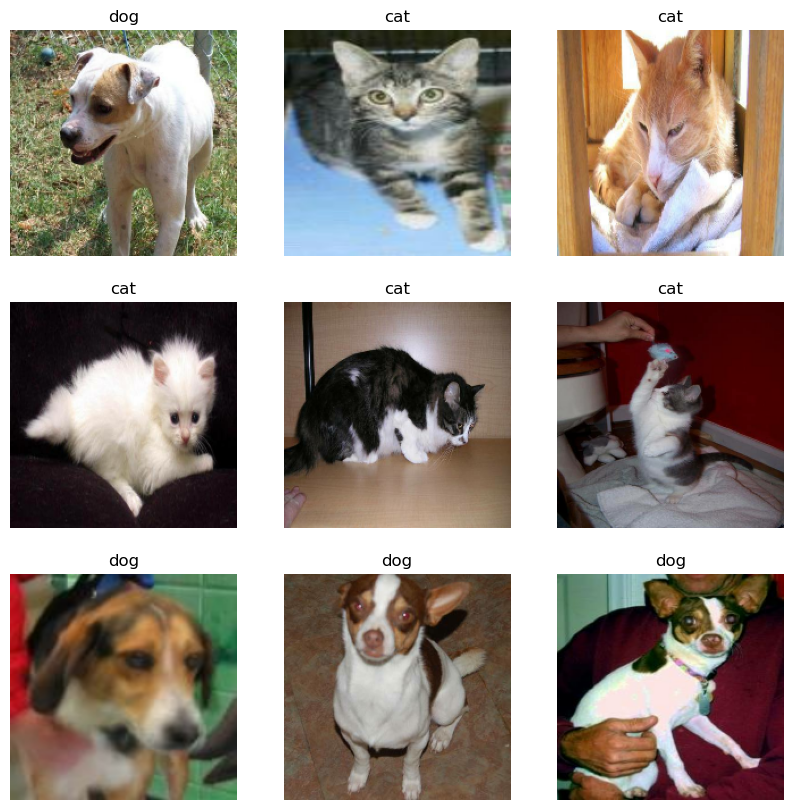

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [54]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [45]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [46]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [55]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.09802185 1.0


In [56]:
num_classes = 2
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [57]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
251/251 [==============================] - 754s 3s/step - loss: 0.6795 - accuracy: 0.5642 - val_loss: 0.6498 - val_accuracy: 0.6008
Epoch 2/10
251/251 [==============================] - 769s 3s/step - loss: 0.5911 - accuracy: 0.6855 - val_loss: 0.5893 - val_accuracy: 0.6931
Epoch 3/10
251/251 [==============================] - 803s 3s/step - loss: 0.5214 - accuracy: 0.7435 - val_loss: 0.5089 - val_accuracy: 0.7540
Epoch 4/10
251/251 [==============================] - 799s 3s/step - loss: 0.4605 - accuracy: 0.7802 - val_loss: 0.5049 - val_accuracy: 0.7570
Epoch 5/10
251/251 [==============================] - 783s 3s/step - loss: 0.4271 - accuracy: 0.8048 - val_loss: 0.4674 - val_accuracy: 0.7824
Epoch 6/10
251/251 [==============================] - 768s 3s/step - loss: 0.3638 - accuracy: 0.8358 - val_loss: 0.4648 - val_accuracy: 0.7899
Epoch 7/10
251/251 [==============================] - 803s 3s/step - loss: 0.2969 - accuracy: 0.8715 - val_loss: 0.5506 - val_accuracy: 0.7959

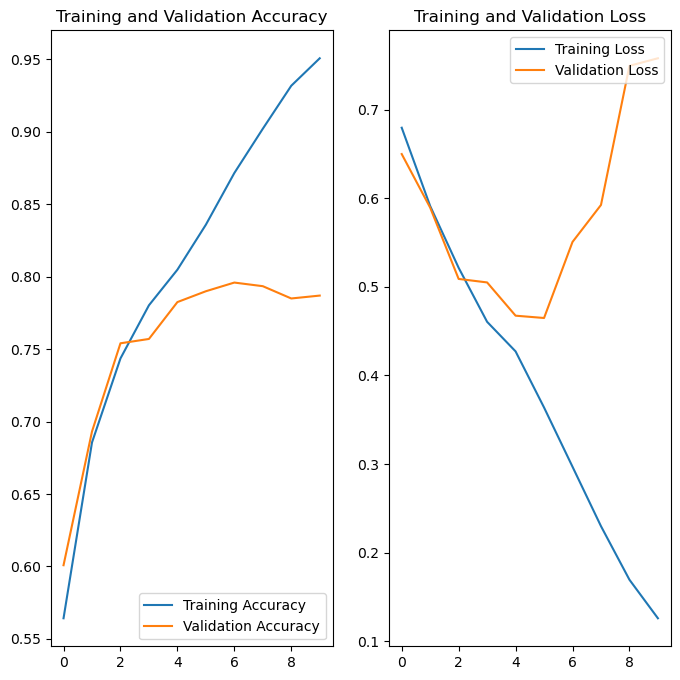

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

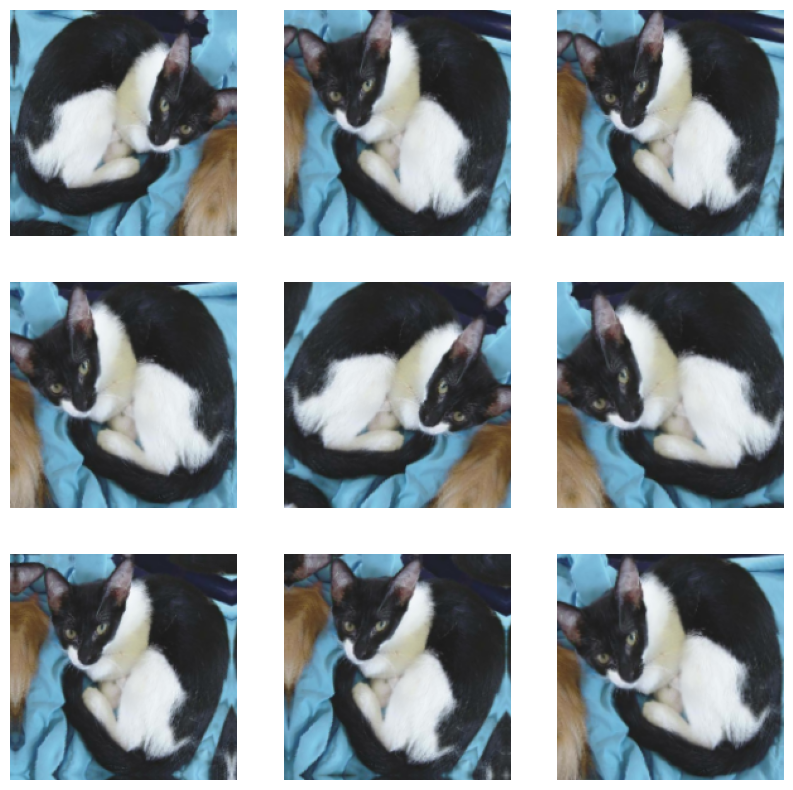

In [61]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [62]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [63]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [64]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds, 
  epochs=epochs
)

Epoch 1/10
251/251 [==============================] - 1120s 4s/step - loss: 0.8471 - accuracy: 0.6330 - val_loss: 7.5541 - val_accuracy: 0.5449
Epoch 2/10
251/251 [==============================] - 1101s 4s/step - loss: 0.5918 - accuracy: 0.6872 - val_loss: 1.0538 - val_accuracy: 0.6517
Epoch 3/10
251/251 [==============================] - 1091s 4s/step - loss: 0.5545 - accuracy: 0.7066 - val_loss: 0.6803 - val_accuracy: 0.6357
Epoch 4/10
251/251 [==============================] - 1112s 4s/step - loss: 0.5177 - accuracy: 0.7397 - val_loss: 0.7222 - val_accuracy: 0.6367
Epoch 5/10
251/251 [==============================] - 1110s 4s/step - loss: 0.4940 - accuracy: 0.7574 - val_loss: 0.5383 - val_accuracy: 0.7365
Epoch 6/10
251/251 [==============================] - 1059s 4s/step - loss: 0.4839 - accuracy: 0.7630 - val_loss: 0.5278 - val_accuracy: 0.7455
Epoch 7/10
251/251 [==============================] - 1049s 4s/step - loss: 0.4714 - accuracy: 0.7720 - val_loss: 0.5951 - val_accuracy:

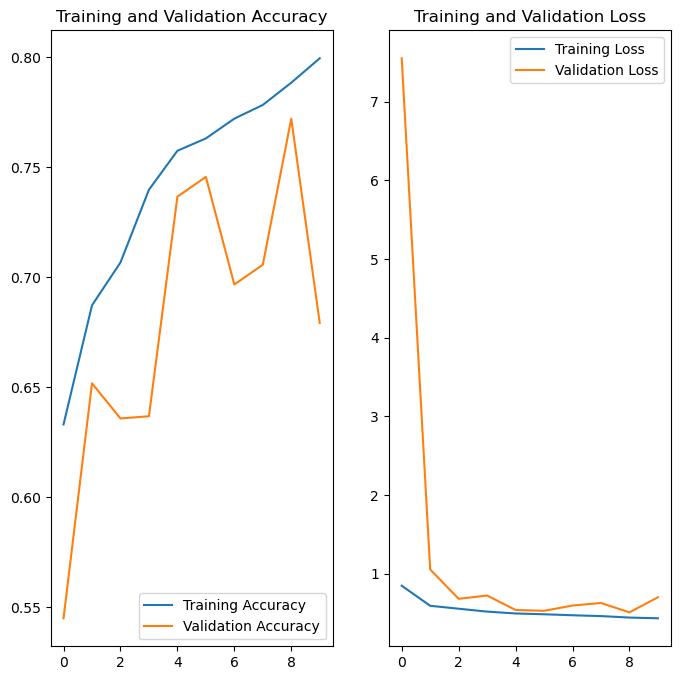

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [76]:
import cv2

img_height = 180
img_width = 180

# Check the path to the image and ensure it's valid
image_path = (r'C:\Users\Gbest\Desktop\Deep Learning\dog_and_cat_class\test\depositphotos_237857380-stock-photo-portrait-adorable-german-pointer-studio.jpg')


test_img = cv2.imread(image_path)

if test_img is not None:
    test_input = cv2.resize(test_img, (img_height, img_width))
    test_input = test_input.reshape((1, img_height, img_width, 3))
    
    # Make a prediction
    result = model.predict(test_input)
    
    # Define a mapping from class indices to class names
    class_names = ['cat', 'dog']
    
    # Find the index with the highest probability
    predicted_class_index = result.argmax()
    
    # Get the corresponding class name
    predicted_class_name = class_names[predicted_class_index]
    
    print(f"The predicted flower is: {predicted_class_name}")
else:
    print("Image could not be loaded.")

1/1 [==============================] - 0s 109ms/step
The predicted flower is: dog
